# Imports and data loading

In [62]:
import gtfparse
import os
from tqdm import tqdm
import re
import numpy as np
import pandas as pd

pd.options.display.max_colwidth = 1000

import seaborn as sns
import glob
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
outdir = '/Users/olgabot/botryllus/adhoc-analysis/2022-apr--gather-botryllus-in-human-mouse-with-kmers/'
# ! mkdir $outdir

## Read botryllus putative MHC Matches

In [3]:
%%time

mhc_parquet =  os.path.join(outdir, "botryllus_gather_mouse_human_results_with_e_values_mhc_chromosomes.parquet")


gather_results_mhc = pd.read_parquet(mhc_parquet
)
print(gather_results_mhc.shape)
gather_results_mhc.head()

(17150858, 25)
CPU times: user 31.7 s, sys: 38.2 s, total: 1min 9s
Wall time: 1min 7s


,i_query,kmer_query,kmer_hp,hashval,name_query,i_found,kmer_found,name_found,n_kmers,intersect_bp,...,genomic_coord,all_homologs_found,transcript_id,n_hashes_query,n_hashes_found,bitscore,extreme_value_distribution,containment_scaled,pseudo_e_value,pseudo_e_value_log10
0,623,DVNLRDQQGKSPIFYAEEQNNLDV,phphpppphpphhhhhppppphph,9053272763448756255,g22187.t1 frame:1,30,RGHLCRTRPTDLVFVVDSSRSVRP,ENST00000373765.5 gene_id=ENSG00000162510.6;tr...,4,20,...,Chr1:30711277-30723585(-),True,ENST00000373765.5,202,85,2.0,0.623465,1.370379e-06,16770.715881,4.224552
1,624,VNLRDQQGKSPIFYAEEQNNLDVM,hphpppphpphhhhhppppphphh,1654375679729437405,g22187.t1 frame:1,31,GHLCRTRPTDLVFVVDSSRSVRPV,ENST00000373765.5 gene_id=ENSG00000162510.6;tr...,4,20,...,Chr1:30711277-30723585(-),True,ENST00000373765.5,202,85,2.0,0.623465,1.370379e-06,16770.715881,4.224552
2,625,NLRDQQGKSPIFYAEEQNNLDVMK,phpppphpphhhhhppppphphhp,2361844746549016494,g22187.t1 frame:1,32,HLCRTRPTDLVFVVDSSRSVRPVE,ENST00000373765.5 gene_id=ENSG00000162510.6;tr...,4,20,...,Chr1:30711277-30723585(-),True,ENST00000373765.5,202,85,2.0,0.623465,1.370379e-06,16770.715881,4.224552
3,626,LRDQQGKSPIFYAEEQNNLDVMKY,hpppphpphhhhhppppphphhph,8601332297558688433,g22187.t1 frame:1,33,LCRTRPTDLVFVVDSSRSVRPVEF,ENST00000373765.5 gene_id=ENSG00000162510.6;tr...,4,20,...,Chr1:30711277-30723585(-),True,ENST00000373765.5,202,85,2.0,0.623465,1.370379e-06,16770.715881,4.224552
4,308,GKEKGTKKSPEIADDVSDNDKADA,hppphpppphphhpphppppphph,4814295539498208365,g22187.t1 frame:1,265,INKRLSKSSATLWNSPSRNRSLQL,ENST00000474796.2 gene_id=ENSG00000116871.16;t...,7,35,...,Chr1:36155965-36180849(+),True,ENST00000474796.2,202,196,2.0,0.628367,2.577309e-07,39190.054231,4.593176


## Use only gather results columns

In [9]:
kmer_cols = ('i_query', 'kmer_query', 'kmer_hp', 'hashval', 'i_found', 'kmer_found', 'found_i')
non_kmer_cols = [x for x in gather_results_mhc.columns if x not in kmer_cols]

In [10]:
gather_results_mhc_no_kmer_info = gather_results_mhc[non_kmer_cols].drop_duplicates()
print(gather_results_mhc_no_kmer_info.shape)
gather_results_mhc_no_kmer_info.head()

(644739, 18)


,name_query,name_found,n_kmers,intersect_bp,containment,symbol,species,homolog_group,genomic_coord,all_homologs_found,transcript_id,n_hashes_query,n_hashes_found,bitscore,extreme_value_distribution,containment_scaled,pseudo_e_value,pseudo_e_value_log10
0,g22187.t1 frame:1,ENST00000373765.5 gene_id=ENSG00000162510.6;tr...,4,20,0.023529,MATN1,human,MATN1---Matn1,Chr1:30711277-30723585(-),True,ENST00000373765.5,202,85,2.0,0.623465,1.370379e-06,16770.715881,4.224552
4,g22187.t1 frame:1,ENST00000474796.2 gene_id=ENSG00000116871.16;t...,7,35,0.010204,MAP7D1,human,MAP7D1---Map7d1,Chr1:36155965-36180849(+),True,ENST00000474796.2,202,196,2.0,0.628367,2.577309e-07,39190.054231,4.593176
11,g22187.t1 frame:1,ENST00000373150.8 gene_id=ENSG00000116871.16;t...,7,35,0.010526,MAP7D1,human,MAP7D1---Map7d1,Chr1:36155965-36180849(+),True,ENST00000373150.8,202,190,2.0,0.628248,2.742657e-07,37978.118875,4.579533
18,g22187.t1 frame:1,ENST00000373151.6 gene_id=ENSG00000116871.16;t...,7,35,0.010204,MAP7D1,human,MAP7D1---Map7d1,Chr1:36155965-36180849(+),True,ENST00000373151.6,202,196,2.0,0.628367,2.577309e-07,39190.054231,4.593176
25,g22187.t1 frame:1,ENST00000372307.7 gene_id=ENSG00000196517.13;t...,3,15,0.017391,SLC6A9,human,SLC6A9---Slc6a9,Chr1:43996483-44031492(-),False,ENST00000372307.7,202,115,2.0,0.625723,7.486571e-07,22829.492766,4.358496


In [11]:
mhc_parquet_no_kmer = os.path.join(
    outdir,
    "botryllus_gather_mouse_human_results_with_e_values_mhc_chromosomes_no_kmer_info.parquet",
)

gather_results_mhc_no_kmer_info.to_parquet(mhc_parquet_no_kmer)

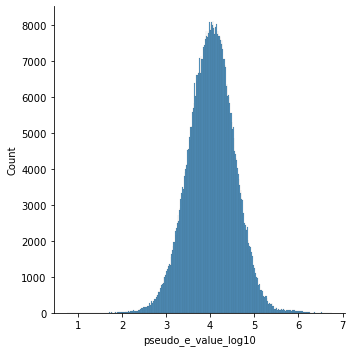

In [12]:
sns.displot(gather_results_mhc_no_kmer_info.pseudo_e_value_log10)

## Read parquet file of human and botrylls transcript coords

In [13]:
parquet = os.path.join(outdir, 'botrllus_human_transcript_coords_for_syntenty.parquet')
botryllus_human_unique_with_coords = pd.read_parquet(parquet)

In [14]:
botryllus_human_unique_with_coords.head()

,botryllus_txpt_id,transcript_id,seqname_botryllus,coord_botryllus,seqname_human,coord_human
0,g22187.t1,ENST00000373765.5,chr12,15384478.0,chr1,30717431.0
4,g22187.t1,ENST00000474796.2,chr12,15384478.0,chr1,36168504.5
11,g22187.t1,ENST00000373150.8,chr12,15384478.0,chr1,36168523.5
18,g22187.t1,ENST00000373151.6,chr12,15384478.0,chr1,36168521.0
25,g22187.t1,ENST00000372307.7,chr12,15384478.0,chr1,44004028.0


In [15]:
print(botryllus_human_unique_with_coords.shape)


(368389, 6)


In [39]:
putative_hla = 'g858.t1', 'g8697.t1'
botryllus_human_unique_with_coords.query('botryllus_txpt_id in @putative_hla')

,botryllus_txpt_id,transcript_id,seqname_botryllus,coord_botryllus,seqname_human,coord_human
0,g858.t1,ENST00000342992.10,chr12,11151429.5,chr2,178666705.0
16,g858.t1,ENST00000589042.5,chr12,11151429.5,chr2,178666706.0
26,g858.t1,ENST00000591111.5,chr12,11151429.5,chr2,178666706.0
42,g858.t1,ENST00000684063.1,chr12,11151429.5,chr3,47255398.5
47,g858.t1,ENST00000265529.7,chr12,11151429.5,chr3,47255923.0
...,...,...,...,...,...,...
7759,g8697.t1,ENST00000483338.1,chr12,12679624.5,chrX,108604880.5
7776,g8697.t1,ENST00000371920.4,chr12,12679624.5,chrX,115298639.0
7781,g8697.t1,ENST00000371410.5,chr12,12679624.5,chrX,119932211.5
7796,g8697.t1,ENST00000371335.4,chr12,12679624.5,chrX,120452900.0


## Merge coords with Gather MHC results with e-values

In [16]:
gather_results_mhc_no_kmer_info.head()

,name_query,name_found,n_kmers,intersect_bp,containment,symbol,species,homolog_group,genomic_coord,all_homologs_found,transcript_id,n_hashes_query,n_hashes_found,bitscore,extreme_value_distribution,containment_scaled,pseudo_e_value,pseudo_e_value_log10
0,g22187.t1 frame:1,ENST00000373765.5 gene_id=ENSG00000162510.6;tr...,4,20,0.023529,MATN1,human,MATN1---Matn1,Chr1:30711277-30723585(-),True,ENST00000373765.5,202,85,2.0,0.623465,1.370379e-06,16770.715881,4.224552
4,g22187.t1 frame:1,ENST00000474796.2 gene_id=ENSG00000116871.16;t...,7,35,0.010204,MAP7D1,human,MAP7D1---Map7d1,Chr1:36155965-36180849(+),True,ENST00000474796.2,202,196,2.0,0.628367,2.577309e-07,39190.054231,4.593176
11,g22187.t1 frame:1,ENST00000373150.8 gene_id=ENSG00000116871.16;t...,7,35,0.010526,MAP7D1,human,MAP7D1---Map7d1,Chr1:36155965-36180849(+),True,ENST00000373150.8,202,190,2.0,0.628248,2.742657e-07,37978.118875,4.579533
18,g22187.t1 frame:1,ENST00000373151.6 gene_id=ENSG00000116871.16;t...,7,35,0.010204,MAP7D1,human,MAP7D1---Map7d1,Chr1:36155965-36180849(+),True,ENST00000373151.6,202,196,2.0,0.628367,2.577309e-07,39190.054231,4.593176
25,g22187.t1 frame:1,ENST00000372307.7 gene_id=ENSG00000196517.13;t...,3,15,0.017391,SLC6A9,human,SLC6A9---Slc6a9,Chr1:43996483-44031492(-),False,ENST00000372307.7,202,115,2.0,0.625723,7.486571e-07,22829.492766,4.358496


In [19]:
gather_results_mhc_no_kmer_info[
    "name_query_no_frame"
] = gather_results_mhc_no_kmer_info.name_query.str.split().str[0]

In [20]:
gather_results_mhc_no_kmer_info_coords = gather_results_mhc_no_kmer_info.merge(
    botryllus_human_unique_with_coords,
    left_on=["name_query_no_frame", "transcript_id"],
    right_on=["botryllus_txpt_id", "transcript_id"],
)
print(gather_results_mhc_no_kmer_info_coords.shape)
gather_results_mhc_no_kmer_info_coords.head()

(368389, 24)


,name_query,name_found,n_kmers,intersect_bp,containment,symbol,species,homolog_group,genomic_coord,all_homologs_found,...,extreme_value_distribution,containment_scaled,pseudo_e_value,pseudo_e_value_log10,name_query_no_frame,botryllus_txpt_id,seqname_botryllus,coord_botryllus,seqname_human,coord_human
0,g22187.t1 frame:1,ENST00000373765.5 gene_id=ENSG00000162510.6;tr...,4,20,0.023529,MATN1,human,MATN1---Matn1,Chr1:30711277-30723585(-),True,...,0.623465,1.370379e-06,16770.715881,4.224552,g22187.t1,g22187.t1,chr12,15384478.0,chr1,30717431.0
1,g22187.t1 frame:1,ENST00000474796.2 gene_id=ENSG00000116871.16;t...,7,35,0.010204,MAP7D1,human,MAP7D1---Map7d1,Chr1:36155965-36180849(+),True,...,0.628367,2.577309e-07,39190.054231,4.593176,g22187.t1,g22187.t1,chr12,15384478.0,chr1,36168504.5
2,g22187.t1 frame:1,ENST00000373150.8 gene_id=ENSG00000116871.16;t...,7,35,0.010526,MAP7D1,human,MAP7D1---Map7d1,Chr1:36155965-36180849(+),True,...,0.628248,2.742657e-07,37978.118875,4.579533,g22187.t1,g22187.t1,chr12,15384478.0,chr1,36168523.5
3,g22187.t1 frame:1,ENST00000373151.6 gene_id=ENSG00000116871.16;t...,7,35,0.010204,MAP7D1,human,MAP7D1---Map7d1,Chr1:36155965-36180849(+),True,...,0.628367,2.577309e-07,39190.054231,4.593176,g22187.t1,g22187.t1,chr12,15384478.0,chr1,36168521.0
4,g22187.t1 frame:1,ENST00000372307.7 gene_id=ENSG00000196517.13;t...,3,15,0.017391,SLC6A9,human,SLC6A9---Slc6a9,Chr1:43996483-44031492(-),False,...,0.625723,7.486571e-07,22829.492766,4.358496,g22187.t1,g22187.t1,chr12,15384478.0,chr1,44004028.0


# Plot synteny!

## Plot to chromosome 6 only

In [21]:
chr6 = gather_results_mhc_no_kmer_info_coords.query('seqname_human == "chr6"')
print(chr6.shape)
chr6.head()

(32069, 24)


,name_query,name_found,n_kmers,intersect_bp,containment,symbol,species,homolog_group,genomic_coord,all_homologs_found,...,extreme_value_distribution,containment_scaled,pseudo_e_value,pseudo_e_value_log10,name_query_no_frame,botryllus_txpt_id,seqname_botryllus,coord_botryllus,seqname_human,coord_human
20,g22187.t1 frame:1,ENST00000379608.9 gene_id=ENSG00000137203.15;t...,7,35,0.025000,TFAP2A,human,TFAP2A---Tfap2a,Chr6:10396677-10419897(-),False,...,0.622925,1.547030e-06,15761.008178,4.197584,g22187.t1,g22187.t1,chr12,15384478.0,chr6,10404534.0
21,g22187.t1 frame:1,ENST00000379613.10 gene_id=ENSG00000137203.15;...,7,35,0.024096,TFAP2A,human,TFAP2A---Tfap2a,Chr6:10396677-10419897(-),False,...,0.623257,1.437217e-06,16366.828608,4.213965,g22187.t1,g22187.t1,chr12,15384478.0,chr6,10405875.5
22,g22187.t1 frame:1,ENST00000319516.8 gene_id=ENSG00000137203.15;t...,7,35,0.024691,TFAP2A,human,TFAP2A---Tfap2a,Chr6:10396677-10419897(-),False,...,0.623038,1.509067e-06,15962.946856,4.203113,g22187.t1,g22187.t1,chr12,15384478.0,chr6,10408755.0
23,g22187.t1 frame:1,ENST00000482890.6 gene_id=ENSG00000137203.15;t...,7,35,0.024096,TFAP2A,human,TFAP2A---Tfap2a,Chr6:10396677-10419897(-),False,...,0.623257,1.437217e-06,16366.828608,4.213965,g22187.t1,g22187.t1,chr12,15384478.0,chr6,10407101.5
24,g22187.t1 frame:1,ENST00000340834.10 gene_id=ENSG00000151914.21;...,6,30,0.003960,DST,human,DST---Dst,Chr6:56457987-56954671(-),False,...,0.630664,3.882361e-08,101606.798945,5.006923,g22187.t1,g22187.t1,chr12,15384478.0,chr6,56500228.0


# HLA

## HLA Top matches only

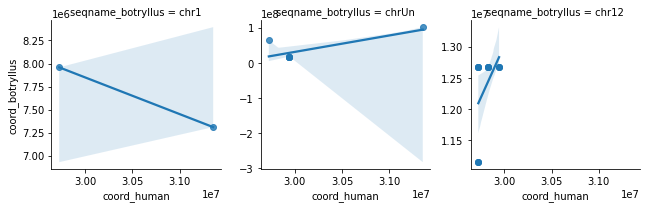

In [36]:
hla_top_matches = gather_results_mhc_no_kmer_info_coords.query('symbol == "HLA" and pseudo_e_value_log10 > 4')

g = sns.FacetGrid(
    data=hla_top_matches,
    # col="seqname_human",
    col="seqname_botryllus",
    # col_order=botryllus_chroms,
    col_wrap=4,
    sharey=False,
)
g.map(sns.regplot, "coord_human", "coord_botryllus")

In [73]:
hla_top_matches_chr12 = hla_top_matches.query('seqname_botryllus == "chr12"')
hla_top_matches_chr12

,name_query,name_found,n_kmers,intersect_bp,containment,symbol,species,homolog_group,genomic_coord,all_homologs_found,...,extreme_value_distribution,containment_scaled,pseudo_e_value,pseudo_e_value_log10,name_query_no_frame,botryllus_txpt_id,seqname_botryllus,coord_botryllus,seqname_human,coord_human
216399,g858.t1 frame:1,"ENST00000376861.5 gene_id=ENSG00000204642.14;transcript_id=ENST00000376861.5;gene_type=protein_coding;gene_name=HLA-F;transcript_type=protein_coding;transcript_name=HLA-F-218;level=2;protein_id=ENSP00000366057.1;transcript_support_level=NA;hgnc_id=HGNC:4963;tag=basic,appris_principal_4,CCDS;ccdsid=CCDS43438.1;havana_gene=OTTHUMG00000031156.6;havana_transcript=OTTHUMT00000195083.1",3,15,0.050000,HLA,human,None,None,None,...,0.613734,0.000003,13811.851244,4.140252,g858.t1,g858.t1,chr12,11151429.5,chr6,29724650.5
216400,g858.t1 frame:1,"ENST00000334668.8 gene_id=ENSG00000204642.14;transcript_id=ENST00000334668.8;gene_type=protein_coding;gene_name=HLA-F;transcript_type=protein_coding;transcript_name=HLA-F-217;level=3;protein_id=ENSP00000334263.4;transcript_support_level=NA;hgnc_id=HGNC:4963;tag=basic,appris_principal_4,CCDS;ccdsid=CCDS43438.1;havana_gene=OTTHUMG00000031156.6",3,15,0.050000,HLA,human,None,None,None,...,0.613734,0.000003,13811.851244,4.140252,g858.t1,g858.t1,chr12,11151429.5,chr6,29724932.5
216401,g858.t1 frame:1,"ENST00000259951.12 gene_id=ENSG00000204642.14;transcript_id=ENST00000259951.12;gene_type=protein_coding;gene_name=HLA-F;transcript_type=protein_coding;transcript_name=HLA-F-216;level=2;protein_id=ENSP00000259951.6;transcript_support_level=NA;hgnc_id=HGNC:4963;tag=basic,Ensembl_canonical,MANE_Select,appris_alternative_2,CCDS;ccdsid=CCDS43437.1;havana_gene=OTTHUMG00000031156.6;havana_transcript=OTTHUMT00000195085.3",3,15,0.035714,HLA,human,None,None,None,...,0.618985,0.000002,19614.811317,4.292584,g858.t1,g858.t1,chr12,11151429.5,chr6,29725365.0
261565,g8697.t1 frame:2,"ENST00000376861.5 gene_id=ENSG00000204642.14;transcript_id=ENST00000376861.5;gene_type=protein_coding;gene_name=HLA-F;transcript_type=protein_coding;transcript_name=HLA-F-218;level=2;protein_id=ENSP00000366057.1;transcript_support_level=NA;hgnc_id=HGNC:4963;tag=basic,appris_principal_4,CCDS;ccdsid=CCDS43438.1;havana_gene=OTTHUMG00000031156.6;havana_transcript=OTTHUMT00000195083.1",3,15,0.033333,HLA,human,None,None,None,...,0.619860,0.000002,13753.812949,4.138423,g8697.t1,g8697.t1,chr12,12679624.5,chr6,29724650.5
261566,g8697.t1 frame:2,"ENST00000334668.8 gene_id=ENSG00000204642.14;transcript_id=ENST00000334668.8;gene_type=protein_coding;gene_name=HLA-F;transcript_type=protein_coding;transcript_name=HLA-F-217;level=3;protein_id=ENSP00000334263.4;transcript_support_level=NA;hgnc_id=HGNC:4963;tag=basic,appris_principal_4,CCDS;ccdsid=CCDS43438.1;havana_gene=OTTHUMG00000031156.6",3,15,0.033333,HLA,human,None,None,None,...,0.619860,0.000002,13753.812949,4.138423,g8697.t1,g8697.t1,chr12,12679624.5,chr6,29724932.5
261567,g8697.t1 frame:2,"ENST00000259951.12 gene_id=ENSG00000204642.14;transcript_id=ENST00000259951.12;gene_type=protein_coding;gene_name=HLA-F;transcript_type=protein_coding;transcript_name=HLA-F-216;level=2;protein_id=ENSP00000259951.6;transcript_support_level=NA;hgnc_id=HGNC:4963;tag=basic,Ensembl_canonical,MANE_Select,appris_alternative_2,CCDS;ccdsid=CCDS43437.1;havana_gene=OTTHUMG00000031156.6;havana_transcript=OTTHUMT00000195085.3",3,15,0.023810,HLA,human,None,None,None,...,0.623362,0.000001,19439.598338,4.288687,g8697.t1,g8697.t1,chr12,12679624.5,chr6,29725365.0
261568,g8697.t1 frame:2,"ENST00000434407.6 gene_id=ENSG00000204642.14;transcript_id=ENST00000434407.6;gene_type=protein_coding;gene_name=HLA-F;transcript_type=protein_coding;transcript_name=HLA-F-220;level=2;protein_id=ENSP00000397376.2;transcript_support_level=NA;hgnc_id=HGNC:4963;tag=basic,CCDS;ccdsid=CCDS43439.1;havana_gene=OTTHUMG00000031156.6;havana_transcript=OTTHUMT00000195084.1",3,15,0.044444,HLA,human,None,None,None,...,0.615776,0.000004,10201.37

In [42]:
hla_top_matches_chr12.to_clipboard()

In [55]:
hla_top_matches_chr12[
    "symbol_with_dashes"
] = hla_top_matches_chr12.name_found.str.extract("gene_name=([\w\-]+)")
hla_top_matches_chr12["transcript_name"] = hla_top_matches_chr12.name_found.str.extract(
    "transcript_name=([\w\-\d]+)"
)
hla_top_matches_chr12_summary = hla_top_matches_chr12[
    ["name_query", "symbol_with_dashes", "transcript_name", "pseudo_e_value_log10"]
].drop_duplicates()
hla_top_matches_chr12_summary

/var/folders/7z/r1593ybs1sj2ks5zzl9vy8840000gn/T/ipykernel_87827/2976228211.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hla_top_matches_chr12[
/var/folders/7z/r1593ybs1sj2ks5zzl9vy8840000gn/T/ipykernel_87827/2976228211.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hla_top_matches_chr12["transcript_name"] = hla_top_matches_chr12.name_found.str.extract(


,name_query,symbol_with_dashes,transcript_name,pseudo_e_value_log10
216399,g858.t1 frame:1,HLA-F,HLA-F-218,4.140252
216400,g858.t1 frame:1,HLA-F,HLA-F-217,4.140252
216401,g858.t1 frame:1,HLA-F,HLA-F-216,4.292584
261565,g8697.t1 frame:2,HLA-F,HLA-F-218,4.138423
261566,g8697.t1 frame:2,HLA-F,HLA-F-217,4.138423
261567,g8697.t1 frame:2,HLA-F,HLA-F-216,4.288687
261568,g8697.t1 frame:2,HLA-F,HLA-F-220,4.008659
261569,g8697.t1 frame:2,HLA-G,HLA-G-204,4.167357
261570,g8697.t1 frame:2,HLA-G,HLA-G-205,4.160302
261571,g8697.t1 frame:2,HLA-G,HLA-G-201,4.160302


In [69]:
hla_top_matches_chr12_summary.groupby(
    ["name_query", "symbol_with_dashes"]
).pseudo_e_value_log10.mean()

name_query        symbol_with_dashes
g858.t1 frame:1   HLA-F                 4.191029
g8697.t1 frame:2  HLA-A                 4.230191
                  HLA-F                 4.143548
                  HLA-G                 4.133795
Name: pseudo_e_value_log10, dtype: float64

In [58]:
hla_top_matches_chr12_summary.to_clipboard()

## Synteny of HLA matches

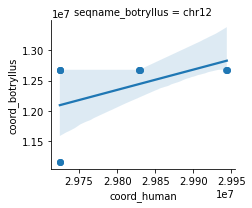

In [41]:

g = sns.FacetGrid(
    data=hla_top_matches_chr12,
    # col="seqname_human",
    col="seqname_botryllus",
    # col_order=botryllus_chroms,
    col_wrap=4,
    sharey=False,
)
g.map(sns.regplot, "coord_human", "coord_botryllus")

## Get k-mers from HLA

In [64]:
hla_kmers = gather_results_mhc.query(
    'name_query in @hla_top_matches_chr12_summary.name_query and symbol == "HLA"'
)
hla_kmers[
    "symbol_with_dashes"
] = hla_kmers.name_found.str.extract("gene_name=([\w\-]+)")
hla_kmers["transcript_name"] = hla_kmers.name_found.str.extract(
    "transcript_name=([\w\-\d]+)"
)

In [67]:
hla_kmers.head()

,i_query,kmer_query,kmer_hp,hashval,name_query,i_found,kmer_found,name_found,n_kmers,intersect_bp,...,transcript_id,n_hashes_query,n_hashes_found,bitscore,extreme_value_distribution,containment_scaled,pseudo_e_value,pseudo_e_value_log10,symbol_with_dashes,transcript_name
74,836,EMESKIERTWVVNLIAGSLRDEGD,phppphppphhhphhhhphppphp,2088024015223878083,g858.t1 frame:1,276,RYTCHVQHEGLPQPLILRWEQSPQ,"ENST00000376861.5 gene_id=ENSG00000204642.14;transcript_id=ENST00000376861.5;gene_type=protein_coding;gene_name=HLA-F;transcript_type=protein_coding;transcript_name=HLA-F-218;level=2;protein_id=ENSP00000366057.1;transcript_support_level=NA;hgnc_id=HGNC:4963;tag=basic,appris_principal_4,CCDS;ccdsid=CCDS43438.1;havana_gene=OTTHUMG00000031156.6;havana_transcript=OTTHUMT00000195083.1",3,15,...,ENST00000376861.5,242,60,2.0,0.613734,0.000003,13811.851244,4.140252,HLA-F,HLA-F-218
75,837,MESKIERTWVVNLIAGSLRDEGDY,hppphppphhhphhhhphppphph,393105819462812905,g858.t1 frame:1,277,YTCHVQHEGLPQPLILRWEQSPQP,"ENST00000376861.5 gene_id=ENSG00000204642.14;transcript_id=ENST00000376861.5;gene_type=protein_coding;gene_name=HLA-F;transcript_type=protein_coding;transcript_name=HLA-F-218;level=2;protein_id=ENSP00000366057.1;transcript_support_level=NA;hgnc_id=HGNC:4963;tag=basic,appris_principal_4,CCDS;ccdsid=CCDS43438.1;havana_gene=OTTHUMG00000031156.6;havana_transcript=OTTHUMT00000195083.1",3,15,...,ENST00000376861.5,242,60,2.0,0.613734,0.000003,13811.851244,4.140252,HLA-F,HLA-F-218
76,838,ESKIERTWVVNLIAGSLRDEGDYK,ppphppphhhphhhhphppphphp,1179802928487376471,g858.t1 frame:1,278,TCHVQHEGLPQPLILRWEQSPQPT,"ENST00000376861.5 gene_id=ENSG00000204642.14;transcript_id=ENST00000376861.5;gene_type=protein_coding;gene_name=HLA-F;transcript_type=protein_coding;transcript_name=HLA-F-218;level=2;protein_id=ENSP00000366057.1;transcript_support_level=NA;hgnc_id=HGNC:4963;tag=basic,appris_principal_4,CCDS;ccdsid=CCDS43438.1;havana_gene=OTTHUMG00000031156.6;havana_transcript=OTTHUMT00000195083.1",3,15,...,ENST00000376861.5,242,60,2.0,0.613734,0.000003,13811.851244,4.140252,HLA-F,HLA-F-218
77,836,EMESKIERTWVVNLIAGSLRDEGD,phppphppphhhphhhhphppphp,2088024015223878083,g858.t1 frame:1,276,RYTCHVQHEGLPQPLILRWEQSPQ,"ENST00000334668.8 gene_id=ENSG00000204642.14;transcript_id=ENST00000334668.8;gene_type=protein_coding;gene_name=HLA-F;transcript_type=protein_coding;transcript_name=HLA-F-217;level=3;protein_id=ENSP00000334263.4;transcript_support_level=NA;hgnc_id=HGNC:4963;tag=basic,appris_principal_4,CCDS;ccdsid=CCDS43438.1;havana_gene=OTTHUMG00000031156.6",3,15,...,ENST00000334668.8,242,60,2.0,0.613734,0.000003,13811.851244,4.140252,HLA-F,HLA-F-217
78,837,MESKIERTWVVNLIAGSLRDEGDY,hppphppphhhphhhhphppphph,393105819462812905,g858.t1 frame:1,277,YTCHVQHEGLPQPLILRWEQSPQP,"ENST00000334668.8 gene_id=ENSG00000204642.14;transcript_id=ENST00000334668.8;gene_type=protein_coding;gene_name=HLA-F;transcript_type=protein_coding;transcript_name=HLA-F-217;level=3;protein_id=ENSP00000334263.4;transcript_support_level=NA;hgnc_id=HGNC:4963;tag=basic,appris_principal_4,CCDS;ccdsid=CCDS43438.1;havana_gene=OTTHUMG00000031156.6",3,15,...,ENST00000334668.8,242,60,2.0,0.613734,0.000003,13811.851244,4.140252,HLA-F,HLA-F-217


In [70]:
hla_kmers[
    ["kmer_hp", "kmer_query", "kmer_found", "symbol_with_dashes", "name_query"]
].drop_duplicates()

,kmer_hp,kmer_query,kmer_found,symbol_with_dashes,name_query
74,phppphppphhhphhhhphppphp,EMESKIERTWVVNLIAGSLRDEGD,RYTCHVQHEGLPQPLILRWEQSPQ,HLA-F,g858.t1 frame:1
75,hppphppphhhphhhhphppphph,MESKIERTWVVNLIAGSLRDEGDY,YTCHVQHEGLPQPLILRWEQSPQP,HLA-F,g858.t1 frame:1
76,ppphppphhhphhhhphppphphp,ESKIERTWVVNLIAGSLRDEGDYK,TCHVQHEGLPQPLILRWEQSPQPT,HLA-F,g858.t1 frame:1
3040,hhhhhhhhhhhhhhhhphhhhhhh,GMGMGIPPPLPPGMLGRLPFPPPM,PIVGIVAGLVVLGAVVTGAVVAAV,HLA-F,g8697.t1 frame:2
3041,hhhhhhhhhhhhhhhphhhhhhhh,MGMGIPPPLPPGMLGRLPFPPPMG,IVGIVAGLVVLGAVVTGAVVAAVM,HLA-F,g8697.t1 frame:2
3042,hhhhhhhhhhhhhhphhhhhhhhh,GMGIPPPLPPGMLGRLPFPPPMGM,VGIVAGLVVLGAVVTGAVVAAVMW,HLA-F,g8697.t1 frame:2
3052,hhhhhhhhhhhhhhhhphhhhhhh,GMGMGIPPPLPPGMLGRLPFPPPM,PIMGIVAGLVVLAAVVTGAAVAAV,HLA-G,g8697.t1 frame:2
3053,hhhhhhhhhhhhhhhphhhhhhhh,MGMGIPPPLPPGMLGRLPFPPPMG,IMGIVAGLVVLAAVVTGAAVAAVL,HLA-G,g8697.t1 frame:2
3054,hhhhhhhhhhhhhhphhhhhhhhh,GMGIPPPLPPGMLGRLPFPPPMGM,MGIVAGLVVLAAVVTGAAVAAVLW,HLA-G,g8697.t1 frame:2
3067,hhhhhhhhhhhhhhhhphhhhhhh,GMGMGIPPPLPPGMLGRLPFPPPM,PIVGIIAGLVLLGAVITGAVVAAV,HLA-A,g8697.t1 frame:2


In [71]:
hla_kmers_cleaned = hla_kmers[
    ["kmer_hp", "kmer_query", "kmer_found", "symbol_with_dashes", "name_query"]
].drop_duplicates()

hla_kmers_cleaned

,kmer_hp,kmer_query,kmer_found,symbol_with_dashes,name_query
74,phppphppphhhphhhhphppphp,EMESKIERTWVVNLIAGSLRDEGD,RYTCHVQHEGLPQPLILRWEQSPQ,HLA-F,g858.t1 frame:1
75,hppphppphhhphhhhphppphph,MESKIERTWVVNLIAGSLRDEGDY,YTCHVQHEGLPQPLILRWEQSPQP,HLA-F,g858.t1 frame:1
76,ppphppphhhphhhhphppphphp,ESKIERTWVVNLIAGSLRDEGDYK,TCHVQHEGLPQPLILRWEQSPQPT,HLA-F,g858.t1 frame:1
3040,hhhhhhhhhhhhhhhhphhhhhhh,GMGMGIPPPLPPGMLGRLPFPPPM,PIVGIVAGLVVLGAVVTGAVVAAV,HLA-F,g8697.t1 frame:2
3041,hhhhhhhhhhhhhhhphhhhhhhh,MGMGIPPPLPPGMLGRLPFPPPMG,IVGIVAGLVVLGAVVTGAVVAAVM,HLA-F,g8697.t1 frame:2
3042,hhhhhhhhhhhhhhphhhhhhhhh,GMGIPPPLPPGMLGRLPFPPPMGM,VGIVAGLVVLGAVVTGAVVAAVMW,HLA-F,g8697.t1 frame:2
3052,hhhhhhhhhhhhhhhhphhhhhhh,GMGMGIPPPLPPGMLGRLPFPPPM,PIMGIVAGLVVLAAVVTGAAVAAV,HLA-G,g8697.t1 frame:2
3053,hhhhhhhhhhhhhhhphhhhhhhh,MGMGIPPPLPPGMLGRLPFPPPMG,IMGIVAGLVVLAAVVTGAAVAAVL,HLA-G,g8697.t1 frame:2
3054,hhhhhhhhhhhhhhphhhhhhhhh,GMGIPPPLPPGMLGRLPFPPPMGM,MGIVAGLVVLAAVVTGAAVAAVLW,HLA-G,g8697.t1 frame:2
3067,hhhhhhhhhhhhhhhhphhhhhhh,GMGMGIPPPLPPGMLGRLPFPPPM,PIVGIIAGLVLLGAVITGAVVAAV,HLA-A,g8697.t1 frame:2


In [ ]:
hla_kmers_cleaned.pivot(index=['

In [74]:
hla_kmers_cleaned.to_clipboard()

In [ ]:
hla_top_matches_chr12_summary

In [28]:
gather_results_mhc_no_kmer_info_coords.seqname_botryllus.unique()

array(['chr12', None, 'chrUn', 'chr6', 'chr10', 'chr2', 'chr4', 'chr1',
       'chr5', 'chr13', 'chr7', 'chr9', 'chr11', 'chr3', 'chr8'],
      dtype=object)

In [32]:
botryllus_chroms = sorted(
    list(
        set(
            gather_results_mhc_no_kmer_info_coords.query(
                'seqname_botryllus != "chrUn"'
            ).seqname_botryllus.dropna()
        )
    ),
    key=lambda x: int(x.split("chr")[-1]),
)
botryllus_chroms

['chr1',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chr10',
 'chr11',
 'chr12',
 'chr13']

2 (12983, 24)
3 (12382, 24)
4 (5897, 24)
5 (449, 24)


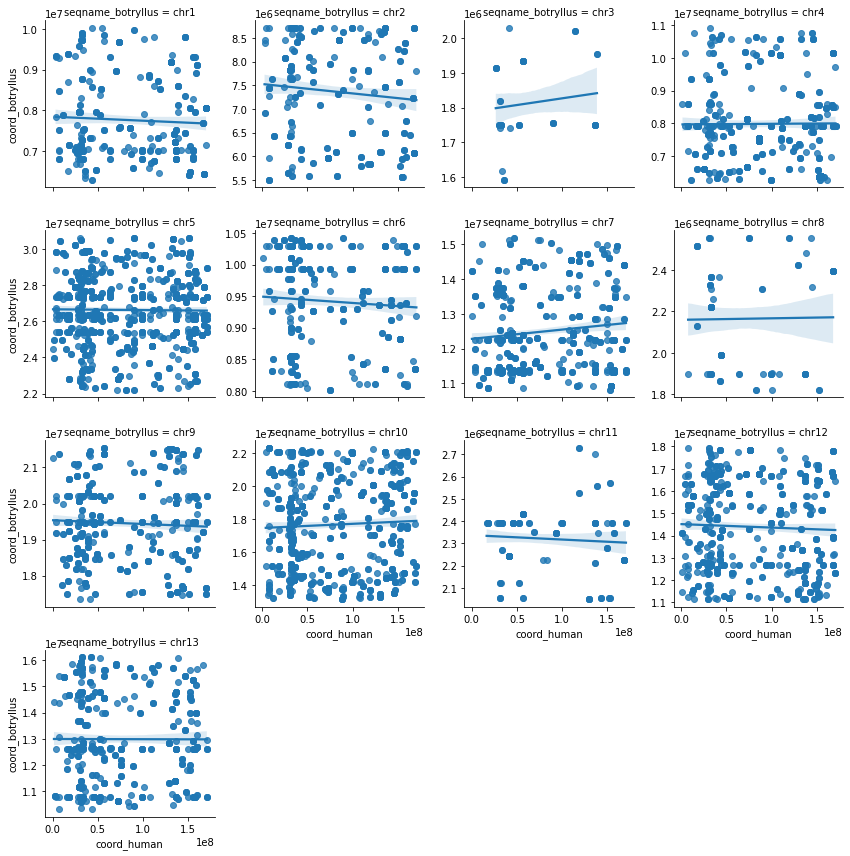

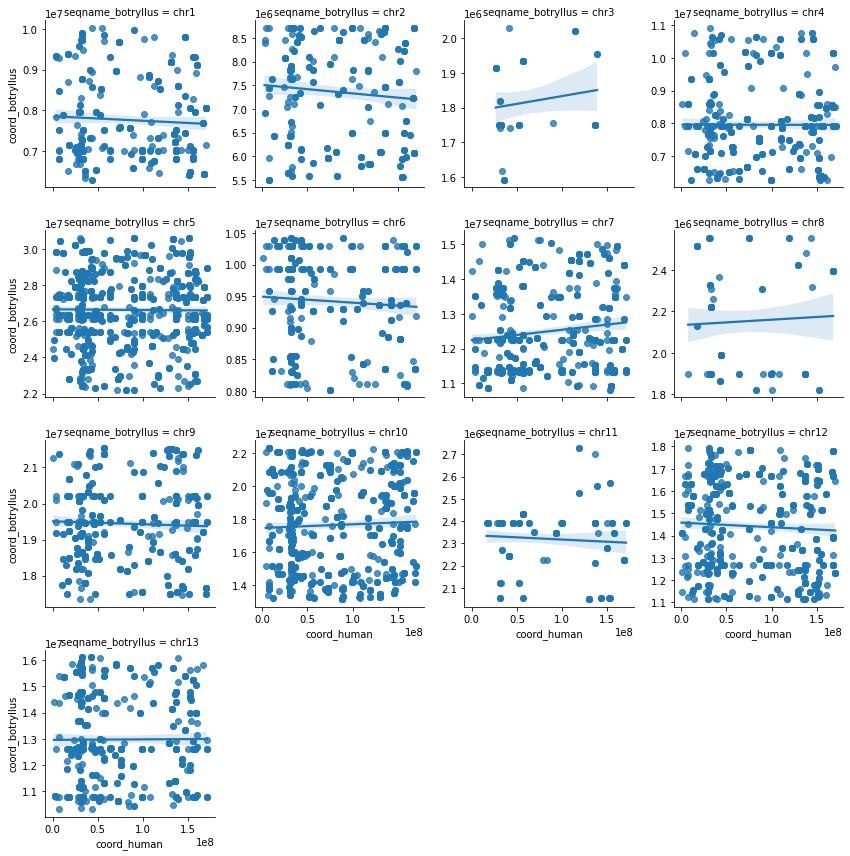

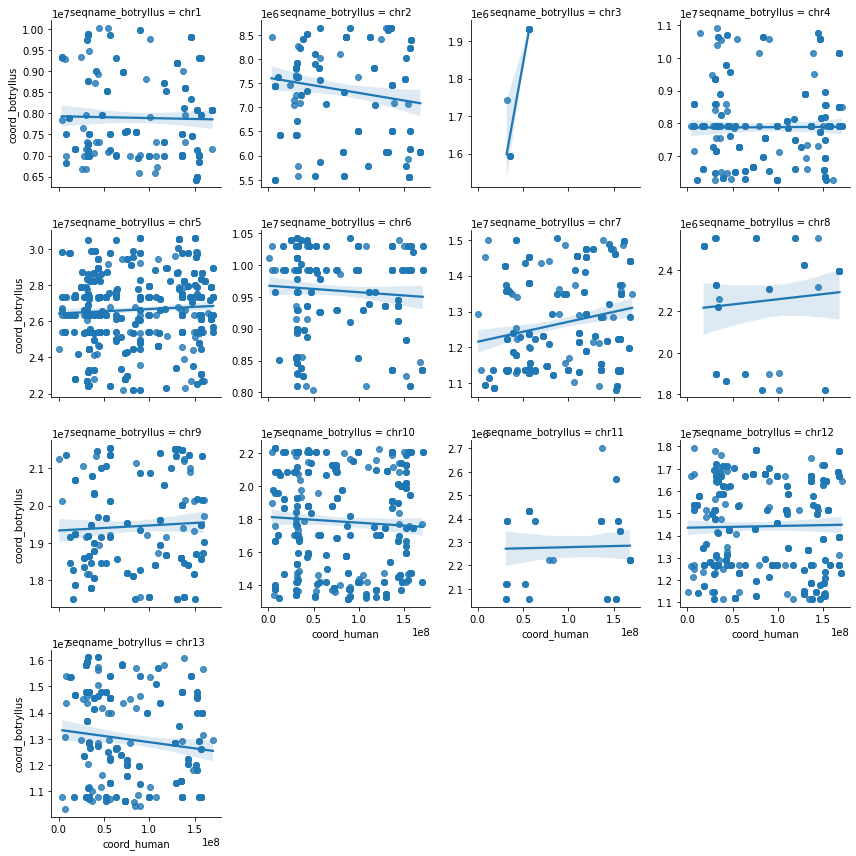

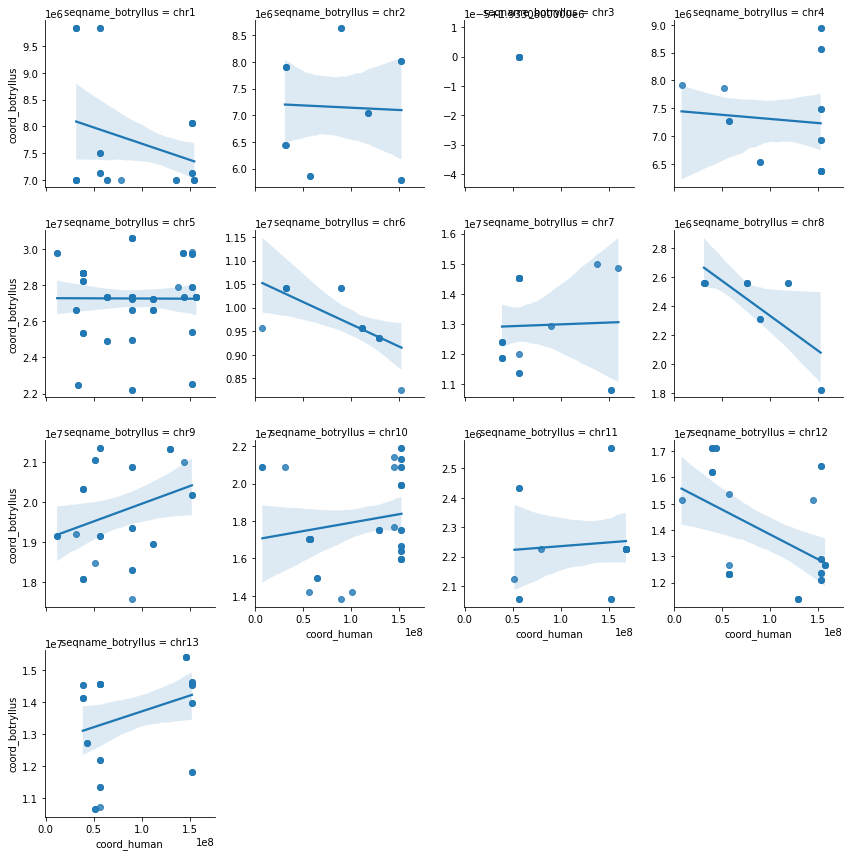

In [33]:
e_value_thresholds = range(2, 6)


for threshold in e_value_thresholds:
    above_threshold = chr6.query(
        'pseudo_e_value_log10 > @threshold and seqname_botryllus != "chrUn"'
    )
    print(threshold, above_threshold.shape)
    g = sns.FacetGrid(
        data=above_threshold,
        # col="seqname_human",
        col="seqname_botryllus",
        col_order=botryllus_chroms,
        col_wrap=4,
        sharey=False,
    )
    g.map(sns.regplot, "coord_human", "coord_botryllus")

## PLot distribution of genes on human coordinates

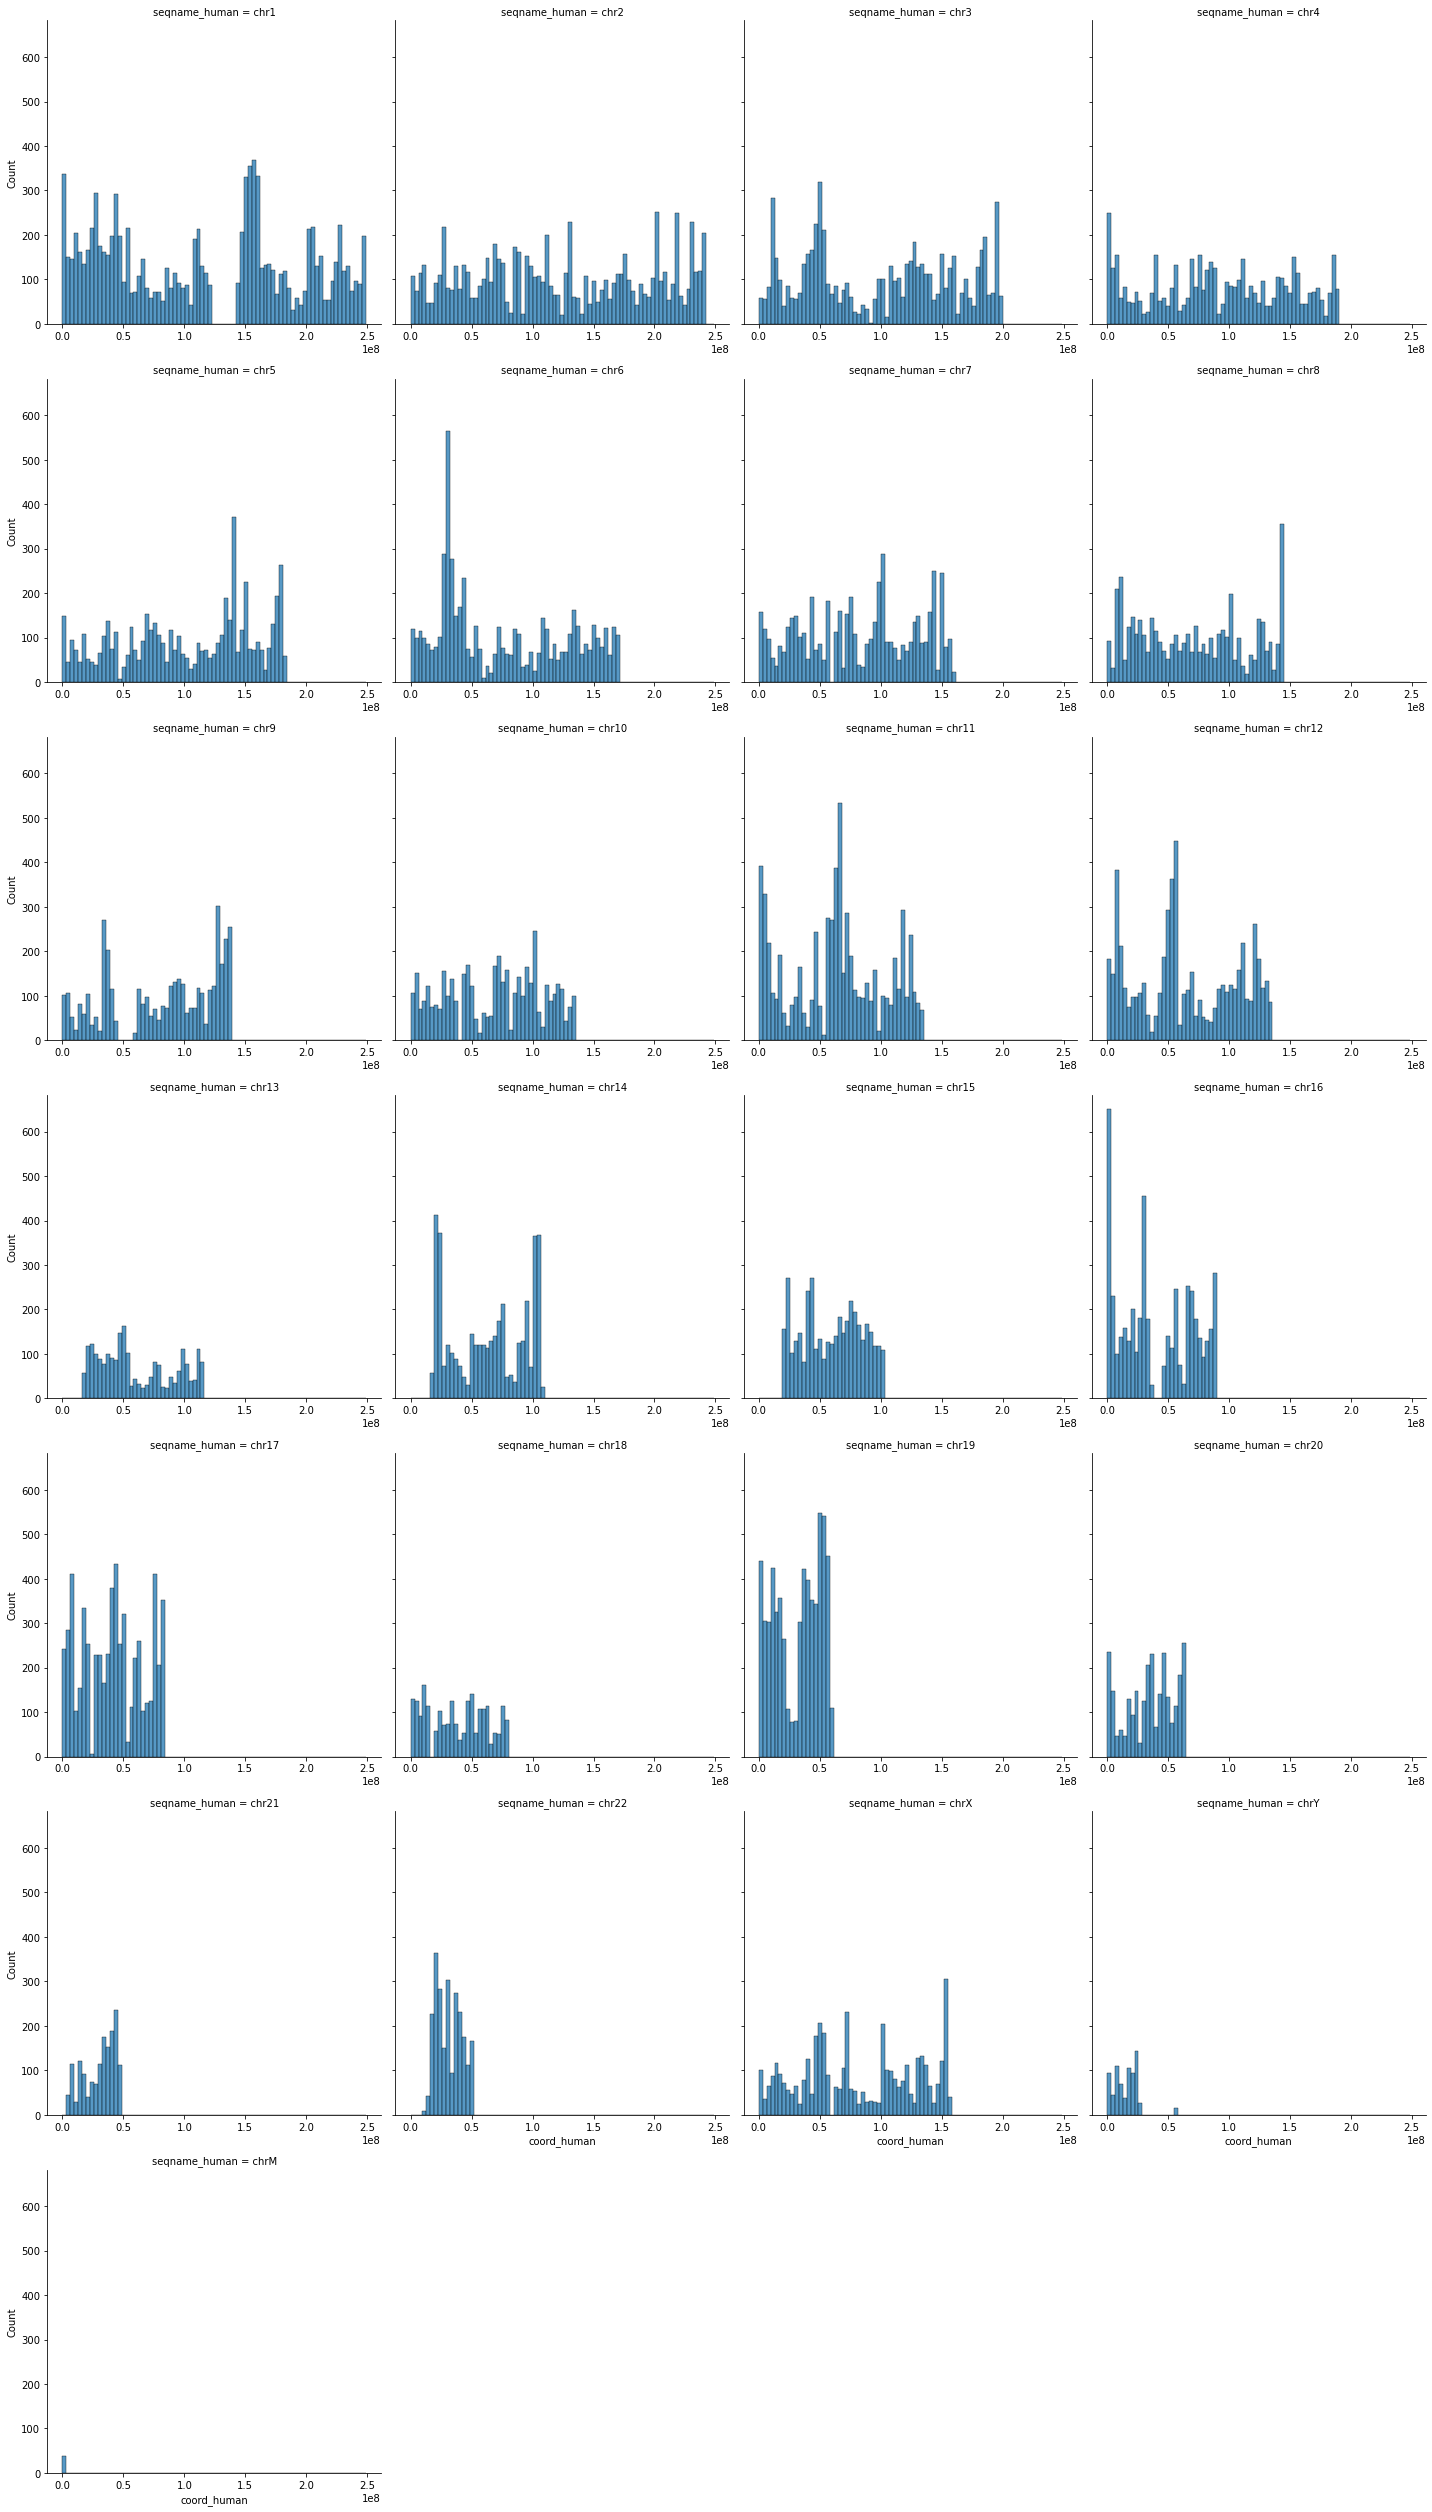

In [157]:
sns.displot(
    x="coord_human",
    data=human_txpt_coords,
    col="seqname_human",
    col_wrap=4,
    facet_kws=dict(sharex=False),
)

## Plot botryllus with chrom6 only

In [150]:
botryllus_human_unique_with_coords.head()

,botryllus_txpt_id,transcript_id,seqname_botryllus,coord_botryllus,seqname_human,coord_human
0,g22187.t1,ENST00000373765.5,chr12,15384478.0,chr1,30717431.0
4,g22187.t1,ENST00000474796.2,chr12,15384478.0,chr1,36168504.5
11,g22187.t1,ENST00000373150.8,chr12,15384478.0,chr1,36168523.5
18,g22187.t1,ENST00000373151.6,chr12,15384478.0,chr1,36168521.0
25,g22187.t1,ENST00000372307.7,chr12,15384478.0,chr1,44004028.0


In [151]:
botryllus_human_unique_with_coords_human_chr6 = (
    botryllus_human_unique_with_coords.query('seqname_human == "chr6"')
)
botryllus_human_unique_with_coords_human_chr6 = (
    botryllus_human_unique_with_coords_human_chr6.sort_values("seqname_botryllus")
)
botryllus_human_unique_with_coords_human_chr6.shape

(32069, 6)

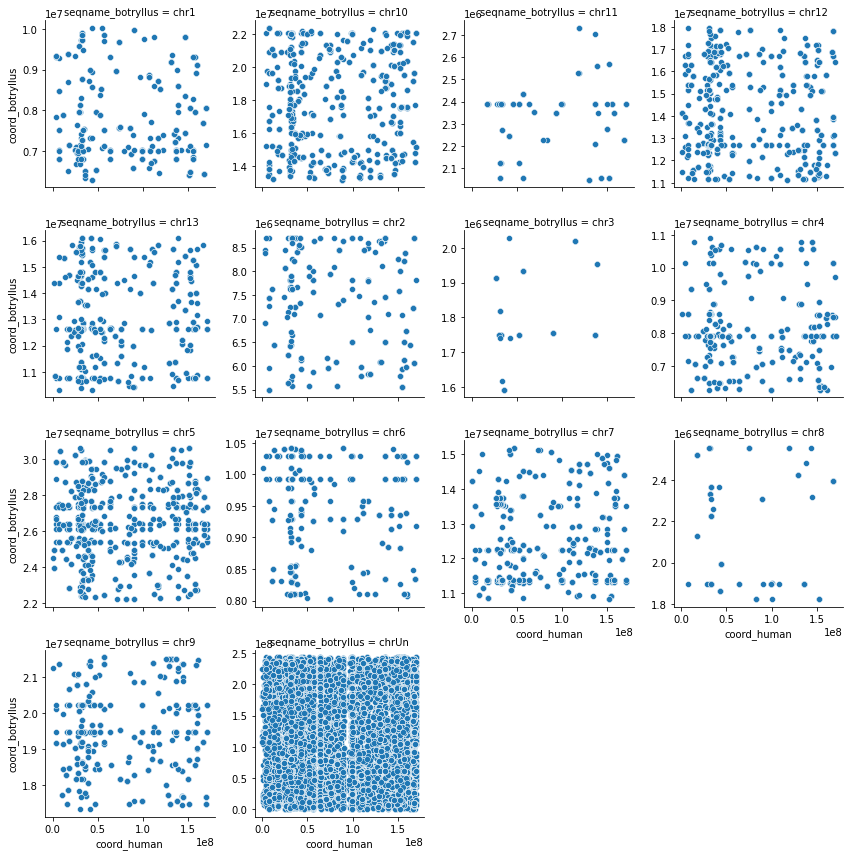

In [153]:
g = sns.FacetGrid(
    data=botryllus_human_unique_with_coords_human_chr6,
    # col="seqname_human",
    col="seqname_botryllus",
    col_wrap=4,
    sharey=False,
)
g.map(sns.scatterplot, "coord_human", "coord_botryllus")

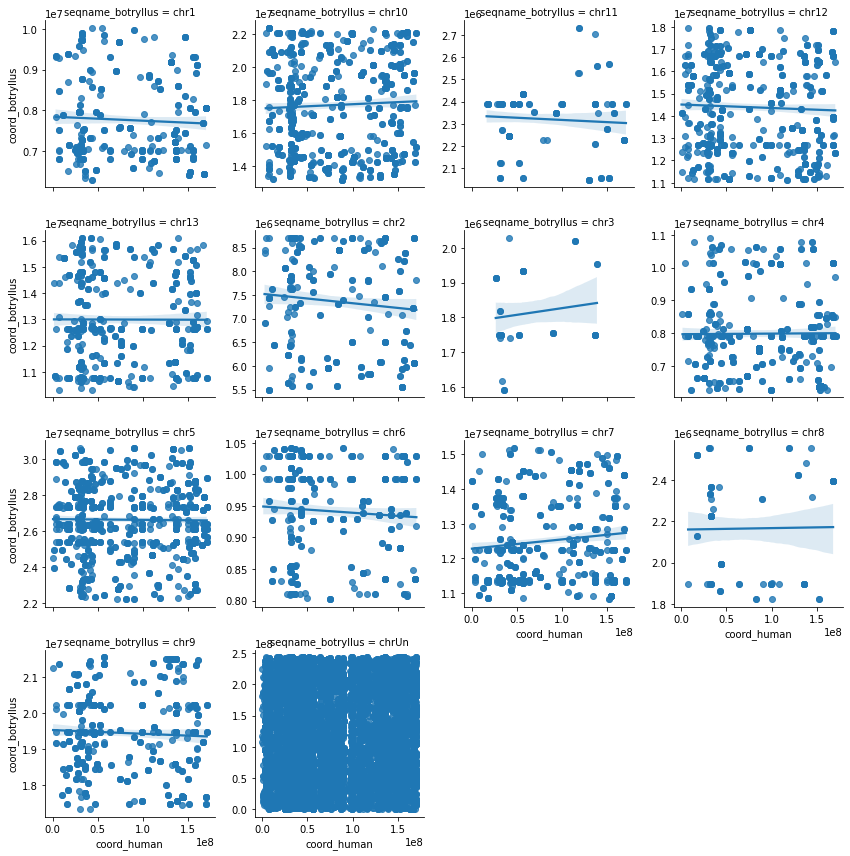

In [160]:
g = sns.FacetGrid(
    data=botryllus_human_unique_with_coords_human_chr6,
    # col="seqname_human",
    col="seqname_botryllus",
    col_wrap=4,
    sharey=False,
)
g.map(sns.regplot, "coord_human", "coord_botryllus")

In [162]:
botryllus_human_unique_with_coords_human_chr6.head()

,botryllus_txpt_id,transcript_id,seqname_botryllus,coord_botryllus,seqname_human,coord_human
193,g10570.t1,ENST00000452085.7,chr1,7309733.0,chr6,116362490.0
172,g10570.t1,ENST00000373127.8,chr1,7309733.0,chr6,41151839.5
177,g10570.t1,ENST00000426005.6,chr1,7309733.0,chr6,41151967.5
182,g10570.t1,ENST00000437044.2,chr1,7309733.0,chr6,41151968.0
187,g10570.t1,ENST00000398776.2,chr1,7309733.0,chr6,44171610.5


## Linearly Correlate coordinates

In [166]:
botryllus_human_unique_with_coords_human_chr6.groupby(
    ["seqname_botryllus", "seqname_human"]
).apply(lambda x: x.coord_botryllus.corr(x.coord_human))

seqname_botryllus  seqname_human
chr1               chr6            -0.050838
chr10              chr6             0.043697
chr11              chr6            -0.072592
chr12              chr6            -0.039093
chr13              chr6            -0.002546
chr2               chr6            -0.093055
chr3               chr6             0.136435
chr4               chr6             0.007667
chr5               chr6            -0.011435
chr6               chr6            -0.067223
chr7               chr6             0.110833
chr8               chr6             0.014053
chr9               chr6            -0.047348
chrUn              chr6             0.010032
dtype: float64

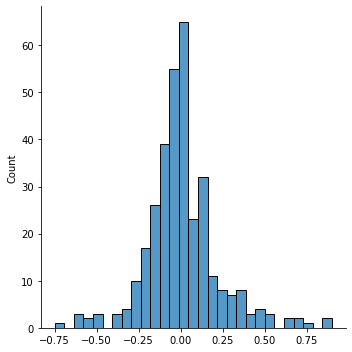

In [169]:
correlations = botryllus_human_unique_with_coords.groupby(
    ["seqname_botryllus", "seqname_human"]
).apply(lambda x: x.coord_botryllus.corr(x.coord_human))
sns.displot(correlations)

In [173]:
correlations[correlations.abs() > 0.25].sort_values()

seqname_botryllus  seqname_human
chr4               chrY            -0.749479
chr12              chrY            -0.599337
chr8               chr20           -0.591858
chr3               chr4            -0.590286
                   chr5            -0.564028
                   chr14           -0.548484
chr10              chrM            -0.500000
chr8               chr11           -0.494727
chr1               chrY            -0.469930
chr8               chr21           -0.386772
chr6               chr21           -0.368324
                   chr9            -0.366468
chr3               chrX            -0.335695
chr11              chr8            -0.329904
chr5               chr22           -0.326979
chr9               chr12           -0.308143
chr1               chr22           -0.269678
chr2               chr18           -0.268274
chr8               chr9            -0.267069
chr5               chrM            -0.262048
chr9               chr9            -0.261048
chr8               chr

## Plot coords

In [128]:
g = sns.FacetGrid(
    data=botryllus_human_unique_with_coords,
    col="seqname_human",
    row="seqname_botryllus",
)

g.map(sns.scatterplot, "coord_human", "coord_botryllus")

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x19b2f5900> (for post_execute):


KeyboardInterrupt: 